In [19]:
import os, sys
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torch import nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
sys.path.append('..')
from vit import ViT

In [33]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [21]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}. Good to go!')
else:
    print('No GPU')

No GPU


## Loading Data
Download train/test zip file from: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition. Should be a file named `dogs-vs-cats-redux-kernels-edition.zip` and place it in the same directory as this notebook.

In [5]:
with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition.zip') as file_zip:
    file_zip.extractall('.')

os.remove('sample_submission.csv')
os.makedirs('data', exist_ok=True)

train_dir = 'data/train'
test_dir = 'data/test'

with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

print(f'Train Data: {len(train_list)}')
print(f'Test Data: {len(test_list)}')

Train Data: 25000
Test Data: 12500


In [6]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

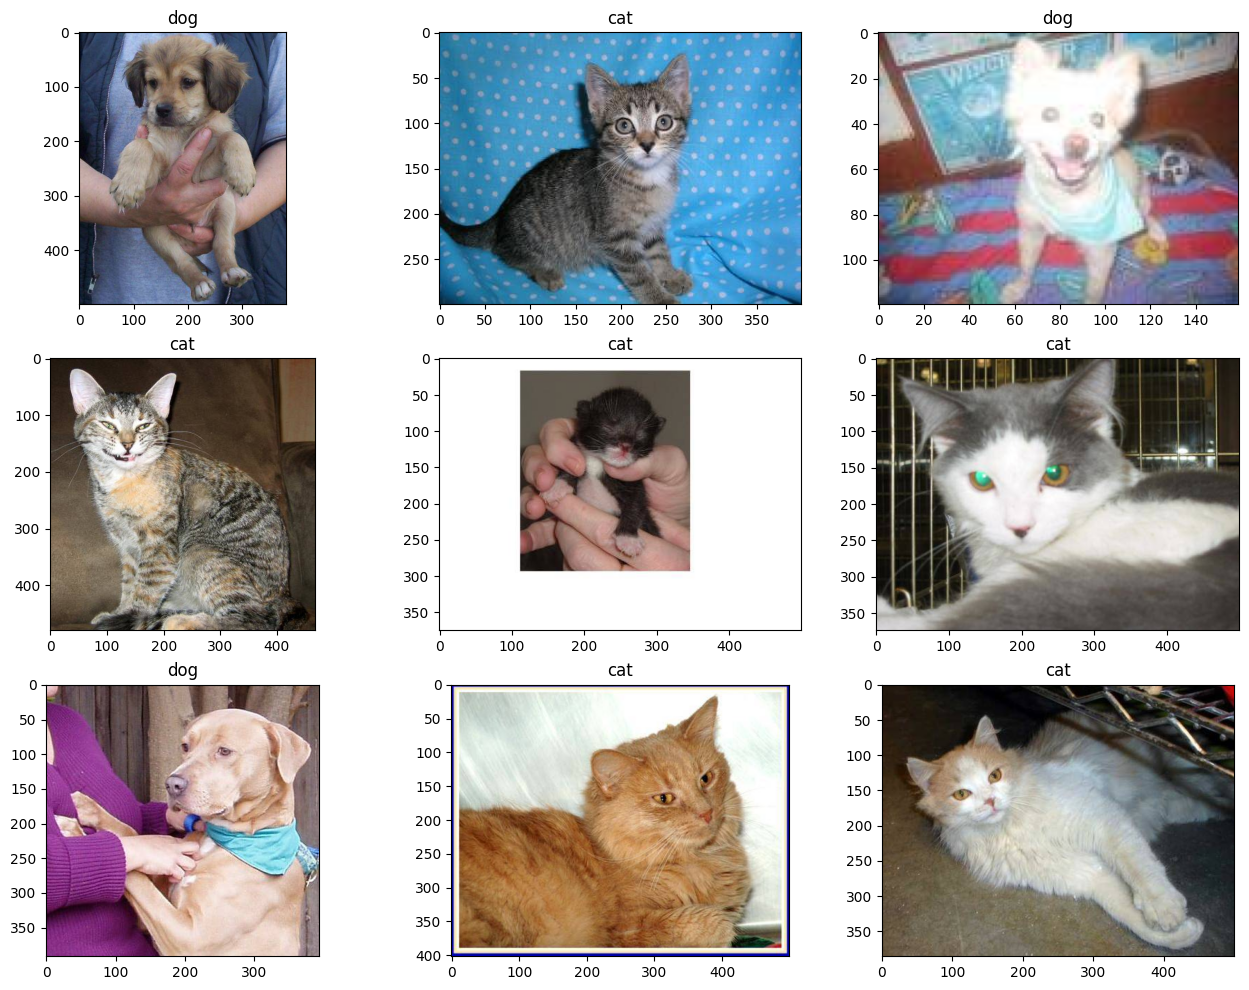

In [69]:
# random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Train/Val Split

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [9]:
train, val = train_test_split(
    train_list, 
    test_size=0.2,
    stratify=labels,
    random_state=seed
)
test = test_list

print(f"Train Data: {len(train)}")
print(f"Validation Data: {len(val)}")
print(f"Test Data: {len(test)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Augmentation

In [23]:
train_transforms = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])


val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
])

test_transforms = val_transforms

In [11]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [34]:
train_data = CatsDogsDataset(train, transform=train_transforms)
valid_data = CatsDogsDataset(val, transform=test_transforms)
test_data = CatsDogsDataset(test, transform=test_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset= valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [32]:
len(train_data), len(train_loader), len(valid_data), len(valid_loader)

(20000, 20000, 5000, 5000)

## Vision Transformer

In [43]:
model = ViT(
    image_size=256,
    patch_size=32, # 16,
    num_classes=2,
    dim=128, # 192,
    depth=12, # 8,
    heads=8, # 4,
    dim_head=48,
    mlp_dim=768,
    dropout=0.1,
    emb_dropout=0.1
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [44]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████| 313/313 [05:26<00:00,  1.04s/it]


Epoch : 1 - loss : 0.6762 - acc: 0.5691 - val_loss : 0.6383 - val_acc: 0.6319



100%|██████████| 313/313 [05:28<00:00,  1.05s/it]


Epoch : 2 - loss : 0.6517 - acc: 0.6057 - val_loss : 0.6510 - val_acc: 0.6025



100%|██████████| 313/313 [05:29<00:00,  1.05s/it]


Epoch : 3 - loss : 0.6431 - acc: 0.6209 - val_loss : 0.6290 - val_acc: 0.6315



100%|██████████| 313/313 [05:59<00:00,  1.15s/it]


Epoch : 4 - loss : 0.6360 - acc: 0.6303 - val_loss : 0.6168 - val_acc: 0.6507



100%|██████████| 313/313 [06:20<00:00,  1.22s/it]


Epoch : 5 - loss : 0.6321 - acc: 0.6305 - val_loss : 0.6062 - val_acc: 0.6671



100%|██████████| 313/313 [06:13<00:00,  1.19s/it]


Epoch : 6 - loss : 0.6267 - acc: 0.6455 - val_loss : 0.5995 - val_acc: 0.6758



100%|██████████| 313/313 [06:03<00:00,  1.16s/it]


Epoch : 7 - loss : 0.6243 - acc: 0.6457 - val_loss : 0.5991 - val_acc: 0.6723



100%|██████████| 313/313 [05:44<00:00,  1.10s/it]


Epoch : 8 - loss : 0.6237 - acc: 0.6454 - val_loss : 0.6028 - val_acc: 0.6614



100%|██████████| 313/313 [05:42<00:00,  1.10s/it]


Epoch : 9 - loss : 0.6225 - acc: 0.6492 - val_loss : 0.6076 - val_acc: 0.6693



100%|██████████| 313/313 [05:44<00:00,  1.10s/it]


Epoch : 10 - loss : 0.6153 - acc: 0.6561 - val_loss : 0.5975 - val_acc: 0.6831



100%|██████████| 313/313 [05:44<00:00,  1.10s/it]


Epoch : 11 - loss : 0.6169 - acc: 0.6583 - val_loss : 0.6207 - val_acc: 0.6363



100%|██████████| 313/313 [05:43<00:00,  1.10s/it]


Epoch : 12 - loss : 0.6125 - acc: 0.6600 - val_loss : 0.5850 - val_acc: 0.6956



100%|██████████| 313/313 [05:43<00:00,  1.10s/it]


Epoch : 13 - loss : 0.6130 - acc: 0.6565 - val_loss : 0.5926 - val_acc: 0.6899



100%|██████████| 313/313 [05:40<00:00,  1.09s/it]


Epoch : 14 - loss : 0.6142 - acc: 0.6552 - val_loss : 0.5834 - val_acc: 0.6889



100%|██████████| 313/313 [05:40<00:00,  1.09s/it]


Epoch : 15 - loss : 0.6059 - acc: 0.6663 - val_loss : 0.5795 - val_acc: 0.6932



100%|██████████| 313/313 [05:40<00:00,  1.09s/it]


Epoch : 16 - loss : 0.6016 - acc: 0.6717 - val_loss : 0.5792 - val_acc: 0.6942



100%|██████████| 313/313 [05:42<00:00,  1.09s/it]


Epoch : 17 - loss : 0.6058 - acc: 0.6698 - val_loss : 0.5756 - val_acc: 0.7004



100%|██████████| 313/313 [05:42<00:00,  1.09s/it]


Epoch : 18 - loss : 0.6036 - acc: 0.6698 - val_loss : 0.5764 - val_acc: 0.6994



100%|██████████| 313/313 [05:43<00:00,  1.10s/it]


Epoch : 19 - loss : 0.5967 - acc: 0.6729 - val_loss : 0.5717 - val_acc: 0.7061



100%|██████████| 313/313 [07:37<00:00,  1.46s/it]


Epoch : 20 - loss : 0.5984 - acc: 0.6749 - val_loss : 0.5680 - val_acc: 0.7087



In [54]:
model.parameters()

<generator object Module.parameters at 0x178bc6f10>

In [56]:
with torch.no_grad():
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)

        val_output = model(data)
        val_loss = criterion(val_output, label)

        acc = (val_output.argmax(dim=1) == label).float().mean()
        epoch_val_accuracy += acc / len(valid_loader)
        epoch_val_loss += val_loss / len(valid_loader)

In [70]:
next(iter(valid_loader))[1], next(iter(train_loader))[0].shape, train_transforms(Image.open(train_list[0])).shape

(tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]),
 torch.Size([64, 3, 224, 224]),
 torch.Size([3, 224, 224]))

In [68]:
img = Image.open(train_list[0])
img = train_transforms(img)[None, :]

model(img)

tensor([[-0.5008,  0.1710]], grad_fn=<AddmmBackward0>)

tensor([[ 0.2557, -0.2278]], grad_fn=<AddmmBackward0>)
tensor([[ 0.6496, -0.7333]], grad_fn=<AddmmBackward0>)
tensor([[-0.8500,  0.3234]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5843, -0.5209]], grad_fn=<AddmmBackward0>)
tensor([[-0.1479, -0.1481]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8767, -0.8803]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0565, -0.1015]], grad_fn=<AddmmBackward0>)
tensor([[-0.0416, -0.2469]], grad_fn=<AddmmBackward0>)
tensor([[ 0.4630, -0.5658]], grad_fn=<AddmmBackward0>)


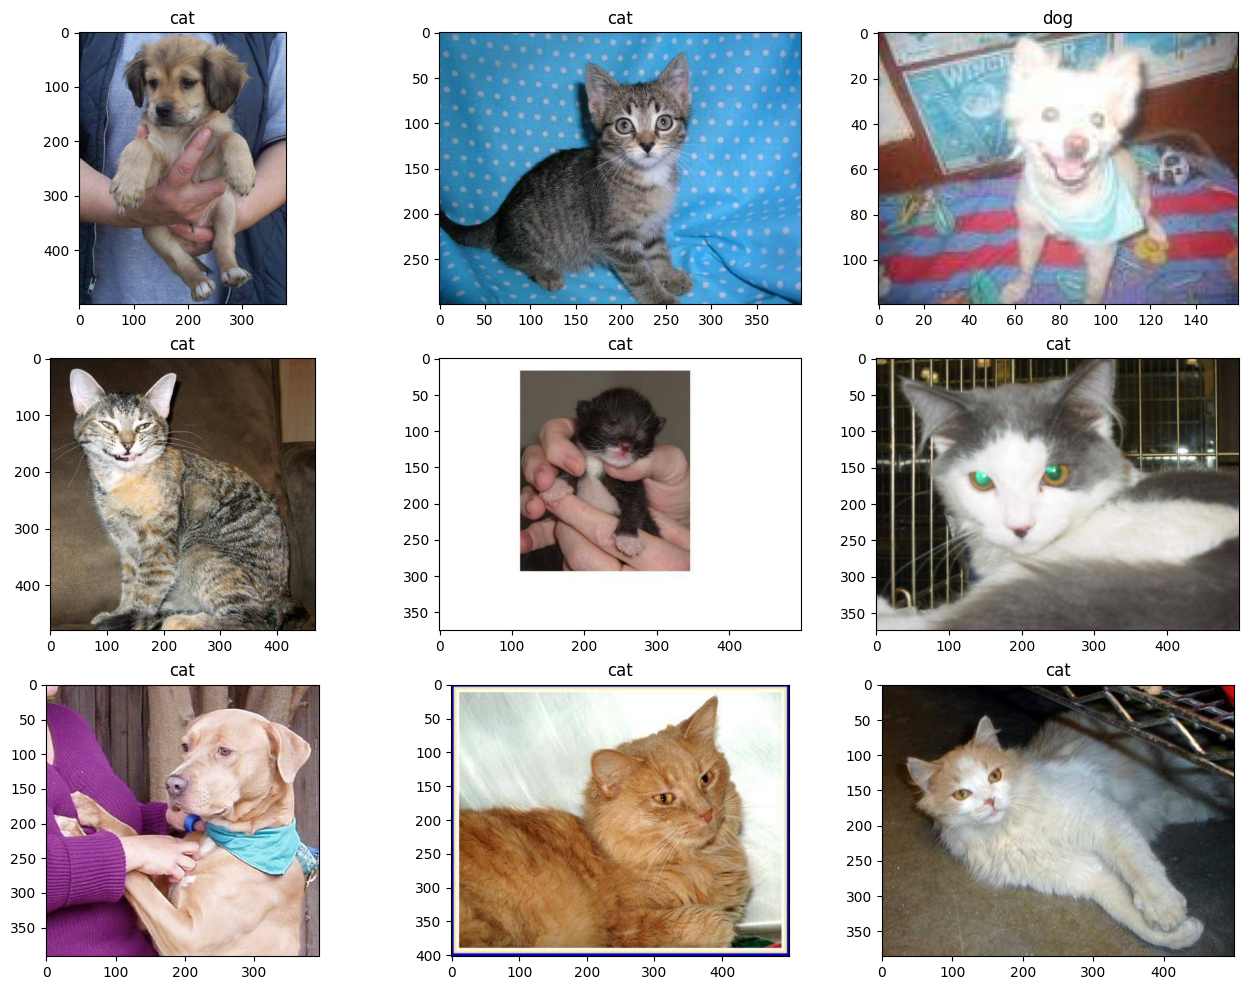

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    transformed_img = train_transforms(img)[None, :]
    label = model(transformed_img)
    print(label)
    ax.set_title("dog" if label.argmax(dim=1) == 1 else "cat")
    ax.imshow(img)